Муратов Никита
БИСТ-20-1

In [1]:
! pip install ftfy
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\netdriver\appdata\local\temp\pip-req-build-r6zw_1bf
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\NetDriver\AppData\Local\Temp\pip-req-build-r6zw_1bf'


In [2]:
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm

import clip
import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt
#импорт всего что нам нужно

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" #выбор видеокарты nvidia если она доступна

#print(clip.available_models())
model, preprocess = clip.load("ViT-B/16", device=device) #выбор самого используемого алгоритма препроцессинга


In [4]:
torch.cuda.is_available()

True

In [7]:
df = pd.read_excel('prompts.xlsx')
prompts = df["prompt"].to_list()
filepaths = df["num"].to_list()
#читаем данные из файла и парсим их в два отдельных списка

FileNotFoundError: [Errno 2] No such file or directory: 'prompts.xlsx'

In [6]:
sims = []
with torch.no_grad():
    for i in tqdm(range(len(df))):
        text_input = clip.tokenize(prompts[i], truncate=True).to(device)
        text_eb = model.encode_text(text_input)
        image = Image.open(filepaths[i]).convert('RGB')
        image = preprocess(image).unsqueeze(0).to(device)
        image_eb = model.encode_image(image)
        sims.append(F.cosine_similarity(text_eb, image_eb).cpu().item())

  0%|          | 0/8192 [00:00<?, ?it/s]

c:\Users\NetDriver\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


KeyboardInterrupt: 

сверху процесс генерации весов путем оценки текста и картинок
была использована небольшая выборка на данный момент, так как с выборкой 1000 он отказался строить гистограмму всвязи с переполнением оперативной памяти

TypeError: object of type 'map' has no len()

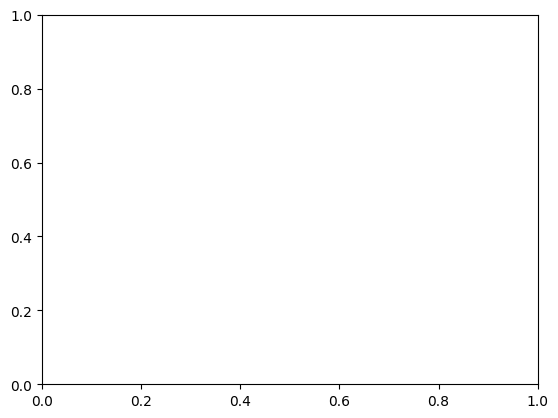

In [ ]:
plt.hist(sims, bins=500, range=(0.1, 0.5))
plt.show()


сверху график весов тэгов
мы видим нормальное распределение, что не удивительно, учитывая природу их происхождения

In [ ]:
sims = map(lambda x: x**5, sims)  # higher sim, higher weight
df['weight'] = pd.Series(sims)

In [ ]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#df.sort_values(by='weight', ascending=False)

In [ ]:
df1 = df.copy()
df1['Prompt'] = df1['Prompt'].str.split(',')

# Создаем новые строки для каждого токена
df1 = df1.explode('Prompt')
df1.sort_values(by='weight', ascending=False)

,Prompt,image_path,weight
1538,a symmetrical tarot card of a brown - skinned shirtless desi mountaineer wearing a scottish tartan kilt on a snowy mountain peak. he has a wooden staff,/kaggle/input/gustavosta-stable-diffusion-prompts-SD2/eval_images/00001538.jpg,0.023408
1538,by albert bierstadt. trending on artstation.,/kaggle/input/gustavosta-stable-diffusion-prompts-SD2/eval_images/00001538.jpg,0.023408
1538,by louis comfort tiffany,/kaggle/input/gustavosta-stable-diffusion-prompts-SD2/eval_images/00001538.jpg,0.023408
1538,homoerotic. by raja ravi varma,/kaggle/input/gustavosta-stable-diffusion-prompts-SD2/eval_images/00001538.jpg,0.023408
1538,art nouveau,/kaggle/input/gustavosta-stable-diffusion-prompts-SD2/eval_images/00001538.jpg,0.023408
...,...,...,...
1906,2 0 0 mm focal length,/kaggle/input/gustavosta-stable-diffusion-prompts-SD2/eval_images/00001906.jpg,0.000191
1906,dungeon background,/kaggle/input/gustavosta-stable-diffusion-prompts-SD2/eval_images/00001906.jpg,0.000191
1906,dungeons and dragons kirby character full body side profile portrait,/kaggle/input/gustavosta-stable-diffusion-prompts-SD2/eval_images/00001906.jpg,0.000191
1906,trending on artstation,/kaggle/input/gustavosta-stable-diffusion-prompts-SD2/eval_images/00001906.jpg,0.000191


В данной работе мы получили на выходе список тэгов для генеративной нейросети и их весов.
Входными данными являются набор сгенерированных изображение нейросетью stable diffusion 2.0 (без доп моделей) и тэги, использованые при генерации через неё же
Мы парсим эти данные, и в дальнейшем через модуль clip от компании open ai оцениваем, какой бы вес имела данное изображение при построении новой нейронной модели из этих данных.
Почему мы верем этим данным? Clip используется для выставления весов во всех современных генеративных сетях.
Зачем нам эти данные? Все современные нейросети генерации изображений используют схожие датасеты, а значит и конкретные тэги с их весами там не будут иметь сильной разницы.
По факту мы ревёрс инженирим данные, которые в нормальных условиях просто не собираются, т.к. для этого пришлос бы потратить очень много ресурсов. Пройтись по генерированым нейросетью изображениям куда быстрее чем проходится по всем изображениям датасета stable diffusion и выставлять веса там, так как тот дата сет весит не один террабайт.
Почему нам важно знать вес тэга? Потому что чем меньше его вес, тем более вероятна так называемая галлюцинация нейросети. Большие веса в свою очередь могут перевесить все остальные теги, и надо будет этот тэг как то уменьшать в весе, что например делается через {"ваш тэг"} или ("ваш тэг":0.8) в stable diffusion 2.0
Используя эти данные мы можем получить куда более предсказуймый результат генерации, нежели генерируя вслепую или на ощупь, и тем более можем в дальнейшем помогать пользователю подбирать нужные ему тэги.
Тема моего диплома: Разработка программного обеспечения для улучшения генерации изображений на основе промптов.